# Face tracking pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and tracking on an image dataset using MTCNN.

In [1]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv, cv2
from PIL import Image, ImageDraw, ImageFont
from IPython import display

#### Determine if an nvidia GPU is available

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See `help(MTCNN)` for more details.

In [3]:
mtcnn = MTCNN(keep_all=True, device=device, image_size=128)
classes = ["masked", "masked_sunglasses", "neutral", "sunglasses"]

#### Get a sample video

We begin by loading a video with some faces in it. The `mmcv` PyPI package by mmlabs is used to read the video frames (it can be installed with `pip install mmcv`). Frames are then converted to PIL images.

In [4]:
video = mmcv.VideoReader('masked.mp4')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

display.Video('masked.mp4', width=640)

#### Run video through MTCNN

We iterate through each frame, detect faces, and draw their bounding boxes on the video frames.

In [5]:
frames_tracked = []

model = torch.load("../classifier/model_9.pth")
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = mtcnn.detect(frame)

    # Save cropped images
    img = mtcnn(frame, save_path="detected/masked/" + str(i) + ".jpg")
    
    if(img is not None):
        result = model(img.to(device))
        out_label = torch.argmax(result, dim=1)
        out = out_label.cpu().detach().numpy()
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    if(boxes is not None):
        for out1, box in zip(out, boxes):
            draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
            draw.text((box[0]-10, box[1]-10), classes[out1], font=ImageFont.truetype('arial', 20), fill=(255,255,0,255))
    else:
        continue
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
    
print('\nDone')

Tracking frame: 146
Done


#### Display detection

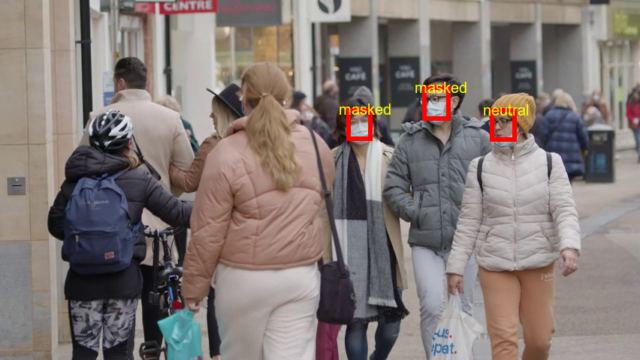

In [11]:
d = display.display(frames_tracked[72], display_id=True)

#### Save tracked video

In [7]:
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter('masked_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()


#### Detect face in image

In [8]:
# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=128, margin=5)

from PIL import Image

img = Image.open("examples/arnold.jpg")

# Get cropped and prewhitened image tensor
img_cropped = mtcnn(img, save_path="detected/samples/arnold.jpg")